### Pharmacokinetic model of a cancer drug

Pharmacokinetics, Lymph Node Uptake, and Mechanistic PK Model of Near-Infrared Dye-Labeled Bevacizumab After IV and SC Administration in Mice

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3326166/


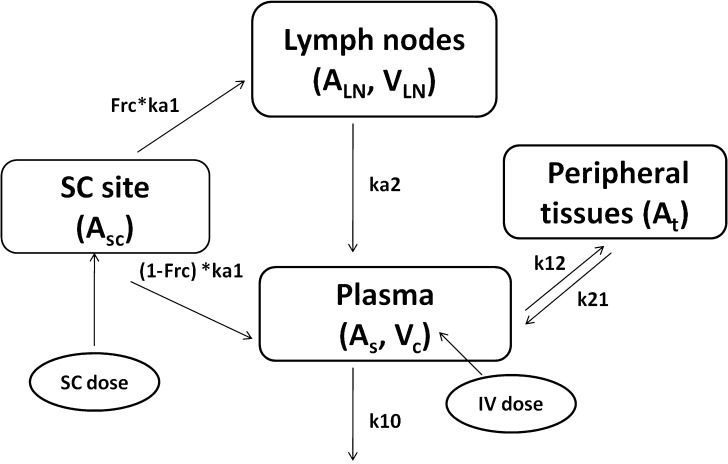

In [17]:
import matplotlib.pyplot as plt
import sympy
import numpy
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.ode import OdeModel, simulate_ode_model

In [18]:
c = {
    'As_iv': Concept(name='As_iv'),
    'At_iv': Concept(name='At_iv'),
    'As_sc': Concept(name='As_sc'),
    'At_sc': Concept(name='At_sc'),
    'ALN_sc': Concept(name='ALN_sc'),
    'A_sc': Concept(name='A_sc')
}

As_iv, At_iv, As_sc, At_sc, ALN_sc, A_sc = sympy.symbols('As_iv At_iv As_sc At_sc ALN_sc A_sc')
ka1, ka2, k10, k12, k21, Frc, SC_dose, IV_dose, BIO = sympy.symbols('ka1 ka2 k10 k12 k21 Frc SC_dose IV_dose BIO')

In [19]:
parameters = {
    'ka1': Parameter(name='ka1', value=None),
    'ka2': Parameter(name='ka2', value=None),
    'k10': Parameter(name='k10', value=None),
    'k12': Parameter(name='k12', value=None),
    'k21': Parameter(name='k21', value=None),
    'Frc': Parameter(name='Frc', value=None),
    'BIO': Parameter(name='BIO', value=None),
}


templates = [
    # IV dose to plasma/tissue
    NaturalConversion(subject=c['As_iv'], outcome=c['At_iv'], rate_law=As_iv*k12),
    NaturalConversion(subject=c['At_iv'], outcome=c['As_iv'], rate_law=At_iv*k21),
    NaturalDegradation(subject=c['As_iv'], rate_law=As_iv*k10),
    
    # SC dose to plasma/tissue
    NaturalConversion(subject=c['As_sc'], outcome=c['At_sc'], rate_law=As_sc*k12),
    NaturalConversion(subject=c['At_sc'], outcome=c['As_sc'], rate_law=At_sc*k21),
    NaturalDegradation(subject=c['As_sc'], rate_law=As_sc*k10),
    
    # SC dose to plasma/lymph nodes
    NaturalConversion(subject=c['ALN_sc'], outcome=c['As_sc'], rate_law=ALN_sc*ka2),
    NaturalConversion(subject=c['A_sc'], outcome=c['As_sc'], rate_law=BIO*(1-Frc)*ka1*A_sc),
    NaturalConversion(subject=c['A_sc'], outcome=c['ALN_sc'], rate_law=BIO*Frc*ka1*A_sc),
]

In [20]:
observables = {
    'A_t': Observable(name='At', expression=At_iv + At_sc),
    'A_s': Observable(name='As', expression=As_iv + As_sc),
}

In [21]:
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
)

In [31]:
model = Model(tm)

In [69]:
om = OdeModel(model, initialized=False)
initial_test = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

params_test = {'k12': 1.0, 'k21': 1.0, 'k10': 1.0, 'ka2': 1.0, 'BIO': 1.0, 'Frc': 1.0,
               'ka1': 1.0}

times_test = numpy.linspace(0, 25, 100)

In [70]:
res = simulate_ode_model(ode_model=om,
                           initials=initial_test,
                           parameters=params_test,
                           times=times_test)

In [82]:
variable_list = list(om.vmap.keys())

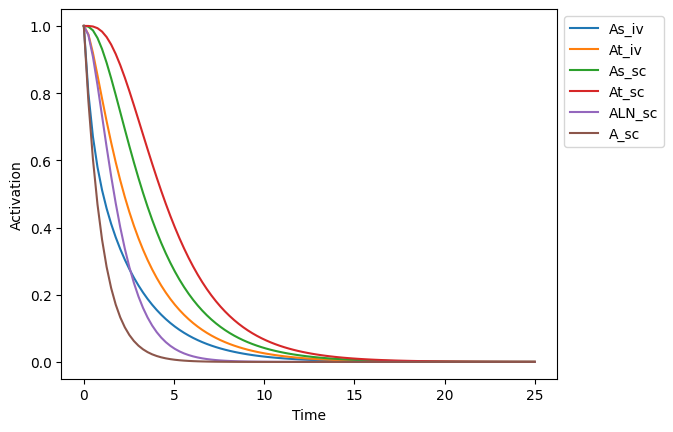

In [83]:
plt.legend(handles = plt.plot(times_test,res), labels=variable_list,loc = 'upper left', bbox_to_anchor=(1,1))
plt.xlabel('Time')
plt.ylabel('Activation')
plt.show()